In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import numpy as np
%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.linalg as la
import pyvista as pv
import imageio.v3 as iio
np.set_printoptions(formatter={"float": "{:10.2f}".format})

In [50]:
from src.experiment import Experiment
from src.pycv.dmcp import dm_to_world
mesh_path = "/home/julian/uni/ushichka-registration/data/formatted/lidar_roi.ply"
mesh_path = "C:/Users/Julian/Nextcloud/Uni/Semester 8/ushichka-registration/data/formatted/lidar_roi.ply"
pvMesh = pv.read(mesh_path)

-0.9999999999999996
[[   -378.23    -430.27     225.58    2060.11]
 [      2.01     109.15     574.71    1183.55]
 [      0.34      -0.74       0.58       5.01]]
1.0000000000000002


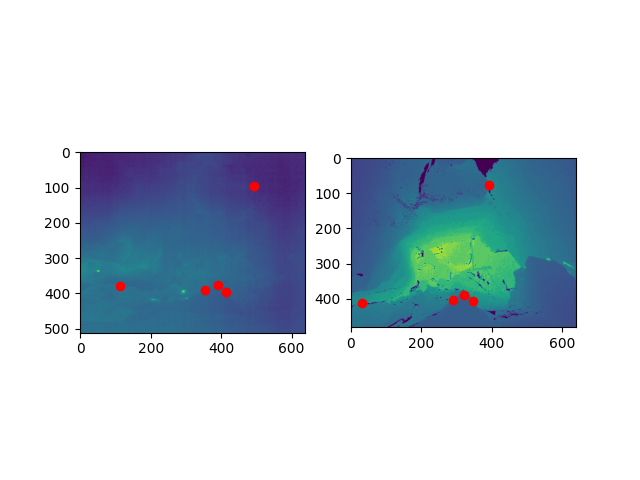

In [51]:
exp = Experiment( "/data/dmcp_experiments/round_05/2018-08-17--cam1", mesh_path)
#exp = Experiment( "/data/dmcp_experiments/round_04/2018-08-17--cam1", mesh_path)

imIm = exp.load_imIm()
imK = exp.load_imK()
imP = exp.load_imP()

dmIm = exp.load_dmIm()
dmK = exp.load_dmK()
dmP = exp.load_dmP()

cps = exp.load_cps()
pts_world = dm_to_world(dmIm, dmK, dmP, cps[:,2:])

trans = exp.load_transform()

def dt(K,P):
    ext = la.inv(K) @ P
    dt = la.det(ext[:3,:3])
    return dt

print(dt(imK,imP))
print(imP)

print(dt(dmK,dmP))

plt.figure()
plt.subplot(1,2,1)
plt.imshow(imIm)
plt.scatter(cps[:,0],cps[:,1],c="r")
plt.subplot(1,2,2)
plt.imshow(dmIm)
plt.scatter(cps[:,2],cps[:,3],c="r")
plt.show()

In [52]:
exp.visualize_3D()

[     -2.17       5.86      -2.45]


In [53]:
plotter = pv.Plotter(notebook=False)
posM = pv.PolyData(np.array(pts_world))
plotter.add_mesh(pvMesh)
plotter.add_mesh(posM, color="blue", point_size=25,render_points_as_spheres=True)
plotter.show()

# transform all cameras in scene

In [54]:
from src.pyushichka import loadCalibration

ps = [loadCalibration(0,r"C:\data\ushichka\2018-08-17"),loadCalibration(1,r"C:\data\ushichka\2018-08-17"),loadCalibration(2,r"C:\data\ushichka\2018-08-17")]
pts = []
for cam in ps:
    K, P = cam
    P_trans = P @ la.inv(trans)
    pos = (la.null_space(P_trans) / la.null_space(P_trans)[-1])[:3].flatten()
    pts.append(pos)

pts = np.array(pts)
plotter = pv.Plotter(notebook=False)
posM = pv.PolyData(np.array(pts))
plotter.add_mesh(pvMesh)
plotter.add_mesh(posM, color="blue", point_size=25,render_points_as_spheres=True)
plotter.show()

D: 3.289521239260813, Uo: 320.04939830822735, Vo:257.9544556169163
[[     -0.60      -0.79       0.14      -0.08]
 [     -0.23       0.34       0.91      -1.01]
 [      0.77      -0.52       0.38       3.29]
 [      0.00       0.00       0.00       1.00]]
D: 5.008090318517899, Uo: 321.75771610469775, Vo:255.0401023216128
[[     -0.93      -0.37       0.07       0.87]
 [     -0.16       0.57       0.81      -0.19]
 [      0.34      -0.74       0.58       5.01]
 [      0.00       0.00       0.00       1.00]]
D: 4.279131398998149, Uo: 319.3674437126702, Vo:254.46441158000394
[[     -1.00      -0.05      -0.02       0.82]
 [     -0.04       0.42       0.91      -0.40]
 [      0.04      -0.91       0.42       4.28]
 [      0.00       0.00       0.00       1.00]]


In [62]:
from src.pycv.perspective import solve_PnP
import cv2
def dmcp(K_native: np.ndarray,P_native: np.ndarray, box_native_x_native: np.ndarray, box_world: np.ndarray, return_raw_pose=False):
    # box is annotated points
    if P_native.shape != (3,4):
        raise Exception(f"P_native shape must be 3,4 bit is {P_native.shape}")

    if K_native.shape != (3,3):
        raise Exception("K_native shape must be 3,3")

    if box_native_x_native.shape[1] != 2:
        raise Exception("box_native_x_native must have 2 columns")

    if box_world.shape[1] != 3:
        raise Exception("box_world must have 3 columns")

    
    def estimate_scaling(K1, P1, K2, P2):
        E1 = np.vstack((la.inv(K1) @ P1, [0, 0, 0, 1]))
        E2 = np.vstack((la.inv(K2) @ P2, [0, 0, 0, 1]))

        # ref: https://math.stackexchange.com/questions/237369/given-this-transformation-matrix-how-do-i-decompose-it-into-translation-rotati/417813
        sv_1 = [la.norm(E1[0:3, 0]), la.norm(E1[0:3, 1]), la.norm(E1[0:3, 2])] # vector of each norm of column in rotation matrix
        sv_2 = [la.norm(E2[0:3, 0]), la.norm(E2[0:3, 1]), la.norm(E2[0:3, 2])]

        sv_1= np.array(sv_1)
        sv_2 = np.array(sv_2)

        scale_factor = la.norm(sv_2) / la.norm(sv_1)
        return scale_factor





    # DMCP Step 1 calibrate camera in world space using annotations
    pose_matrix = solve_PnP(box_world,box_native_x_native,K_native)
    raw_pose = pose_matrix.copy()
    #P = calibrate_dlt(box_native_x_native, box_world)
    #extr = la.inv(K_native) @ P
    #extr_hat = np.vstack((extr,[0,0,0,1]))
    #pose_matrix = la.inv(extr_hat)[:3,:]

    # estimated pose
    print("estimated pose"),
    print(pose_matrix)
    pose_matrix_hat = np.vstack((pose_matrix, [0,0,0,1]))
    extrinsic_matrix_world = la.inv(pose_matrix_hat)[:3,:]
    P = K_native @ extrinsic_matrix_world

    # DMCP Step 2 compute registering transform
    # DMCP Step 2.1 transform world points into camera space
    
    scale_factor = estimate_scaling(K_native,P,K_native, P_native)
    print(f"scale factor {scale_factor}")

    box_world = np.vstack((box_world,12345*(np.random.rand(1234,3)-0.5)))
    box_world_hat = np.hstack((box_world, np.ones((box_world.shape[0],1))))
    box_world_camera = np.matmul(extrinsic_matrix_world, box_world_hat.T).T * scale_factor

    # DMCP Step 2.2 transform camera points into native space
    extrinsic_matrix_native = np.matmul(la.inv(K_native), P_native)
    extrinsic_matrix_native_hat = np.vstack((extrinsic_matrix_native,[0,0,0,1]))
    pose_matrix = la.inv(extrinsic_matrix_native_hat)
    camera_pose_matrix_native = pose_matrix

    box_world_camera_hat = np.hstack((box_world_camera,np.ones((box_world_camera.shape[0],1))))
    box_native_tf = np.matmul(camera_pose_matrix_native, box_world_camera_hat.T).T[:,:3]

    # DMCP Step 2.3
    retval, scale = cv2.estimateAffine3D(box_native_tf, box_world,force_rotation=True)
    A_tf = retval
    A_tf[:3,:3] = A_tf[:3,:3]* scale
    print(scale)

    A_tf_hat = np.vstack((A_tf,[0,0,0,1]))

    #print("retval\n",retval,"scale\n", scale)
    if return_raw_pose:
        return raw_pose, A_tf_hat

    return A_tf_hat

from src.pycv.dmcp import dmcp as dmcp
RP, A = dmcp(imK, imP, cps[:,:2], pts_world, return_raw_pose=True)
ps = [loadCalibration(0,r"C:\data\ushichka\2018-08-17"),loadCalibration(1,r"C:\data\ushichka\2018-08-17"),loadCalibration(2,r"C:\data\ushichka\2018-08-17")]
pts = []
for cam in ps:
    K, P = cam
    P_trans = P @ la.inv(A)
    pos = (la.null_space(P_trans) / la.null_space(P_trans)[-1])[:3].flatten()
    pts.append(pos)

pts = np.array(pts)
plotter = pv.Plotter(notebook=False)
sporig = pv.Sphere(radius=0.5, center=RP[:3,-1])
posM = pv.PolyData(np.array(pts))
plotter.add_mesh(pvMesh)
plotter.add_mesh(posM, color="blue", point_size=25,render_points_as_spheres=True)
plotter.add_mesh(sporig,color="green")
plotter.show()


estimated pose
[[      0.46      -0.33      -0.82       2.29]
 [      0.89       0.16       0.43      -1.33]
 [     -0.01      -0.93       0.36      -1.51]]
scale factor 1.0
0.9997597943492269
D: 3.289521239260813, Uo: 320.04939830822735, Vo:257.9544556169163
[[     -0.60      -0.79       0.14      -0.08]
 [     -0.23       0.34       0.91      -1.01]
 [      0.77      -0.52       0.38       3.29]
 [      0.00       0.00       0.00       1.00]]
D: 5.008090318517899, Uo: 321.75771610469775, Vo:255.0401023216128
[[     -0.93      -0.37       0.07       0.87]
 [     -0.16       0.57       0.81      -0.19]
 [      0.34      -0.74       0.58       5.01]
 [      0.00       0.00       0.00       1.00]]
D: 4.279131398998149, Uo: 319.3674437126702, Vo:254.46441158000394
[[     -1.00      -0.05      -0.02       0.82]
 [     -0.04       0.42       0.91      -0.40]
 [      0.04      -0.91       0.42       4.28]
 [      0.00       0.00       0.00       1.00]]


# calibration space to camera space

In [56]:
ps = [loadCalibration(0,r"C:\data\ushichka\2018-08-17"),loadCalibration(1,r"C:\data\ushichka\2018-08-17"),loadCalibration(2,r"C:\data\ushichka\2018-08-17")] ;
pts = []
for cam in ps:
    K, P = cam
    pos = (la.null_space(P) / la.null_space(P)[-1])[:3].flatten()
    pts.append(pos)

pts = np.array(pts)
pts_hat = np.hstack((pts, np.ones((pts.shape[0],1))))
pts_hat

D: 3.289521239260813, Uo: 320.04939830822735, Vo:257.9544556169163
[[     -0.60      -0.79       0.14      -0.08]
 [     -0.23       0.34       0.91      -1.01]
 [      0.77      -0.52       0.38       3.29]
 [      0.00       0.00       0.00       1.00]]
D: 5.008090318517899, Uo: 321.75771610469775, Vo:255.0401023216128
[[     -0.93      -0.37       0.07       0.87]
 [     -0.16       0.57       0.81      -0.19]
 [      0.34      -0.74       0.58       5.01]
 [      0.00       0.00       0.00       1.00]]
D: 4.279131398998149, Uo: 319.3674437126702, Vo:254.46441158000394
[[     -1.00      -0.05      -0.02       0.82]
 [     -0.04       0.42       0.91      -0.40]
 [      0.04      -0.91       0.42       4.28]
 [      0.00       0.00       0.00       1.00]]


array([[     -2.80,       1.97,      -0.31,       1.00],
       [     -0.93,       4.12,      -2.84,       1.00],
       [      0.64,       4.10,      -1.40,       1.00]])

In [57]:
K, P = loadCalibration(1,r"C:\data\ushichka\2018-08-17")
extr1 = (la.inv(K) @ P)[:3,:] # maps world to camera coordinates

pts_camera = (extr1 @ pts_hat.T).T
pts_camera

D: 5.008090318517899, Uo: 321.75771610469775, Vo:255.0401023216128
[[     -0.93      -0.37       0.07       0.87]
 [     -0.16       0.57       0.81      -0.19]
 [      0.34      -0.74       0.58       5.01]
 [      0.00       0.00       0.00       1.00]]


array([[      2.71,       1.13,       2.42],
       [      0.00,      -0.00,      -0.00],
       [     -1.34,       0.89,       1.39]])

## World space to camera space

using thesis result

In [69]:
pts = np.array([[1.74, 2.02,0.4669],[2.04,-1.34,-1.6],[0.48,-2.1,-0.22]])
pts

pts_hat = np.hstack((pts, np.ones((pts.shape[0],1))))

pts_hat

array([[      1.74,       2.02,       0.47,       1.00],
       [      2.04,      -1.34,      -1.60,       1.00],
       [      0.48,      -2.10,      -0.22,       1.00]])

In [72]:
pose_matrix = RP.copy()
extrinsic_matrix = la.inv(np.vstack((pose_matrix,[0,0,0,1])))[:3,:]
extrinsic_matrix

(extrinsic_matrix @ pts_hat.T).T

array([[      2.70,      -1.12,       2.63],
       [     -0.12,       0.16,       0.17],
       [     -1.53,      -0.74,       1.63]])